### Structured Light

This example discusses helper functions and details for manipulating phase patterns: mainly regarding the contents of `slmsuite.holography.toolbox`.

In [2]:
# Header TODO: hide me with a tag.
# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.spatial.distance as distance

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '../../../..'))

import slmsuite.holography.toolbox as toolbox

from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
santec.py: os has no attribute add_dll_directory.
vimba not installed. Install to use AlliedVision cameras.
PySpin not installed. Install to use FLIR cameras.
pymmcore not installed. Install to use Micro-Manager cameras.
thorlabs.py: os has no attribute add_dll_directory.
thorlabs_tsi_sdk not installed. Install to use Thorlabs cameras.


#### Simple Blazes & Lenses 

Linear phase ramps, also known as blazes after blazed gratings, are a useful analytic function for SLM usage. In this package, `slmsuite.holography.toolbox.blaze` implements this function. We can compute the blaze towards the direction of `vector`. This `vector` is in normalized $\frac{k_x}{k}$ units (see `slmsuite.holography.toolbox.convert_blaze_vector` for more information and unit conversions), and the `x_grid` and `y_grid` coordinates are likewise interpreted to be normalized to wavelength.

In [4]:
x_list = np.arange(2000)
y_list = np.arange(1000)
x_grid, y_grid = np.meshgrid(x_list, y_list)

blaze_phase = toolbox.blaze(grid=(x_grid, y_grid), vector=(.001, .001))

Then, we can render our result using `matplotlib`, with the aid of a quick helper function `plot_phase`:

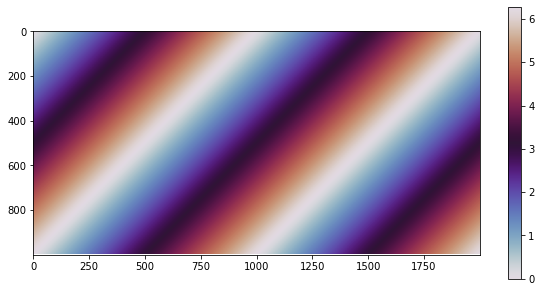

In [5]:
def plot_phase(phase):
    plot_settings = {'cmap':'twilight', 'interpolation':'none'}

    plt.figure(figsize=(10,5))
    plt.imshow(np.mod(phase, 2*np.pi), **plot_settings)
    plt.colorbar()
    plt.show()

plot_phase(blaze_phase)

However, making and tracking `x_grid` and `y_grid` is an unwieldy pain. We encourage users to _not_ do this unless necessary and instead use convenience features builtin to `blaze` and similar toolbox functions. We can pass an SLM directly in place of the grids:

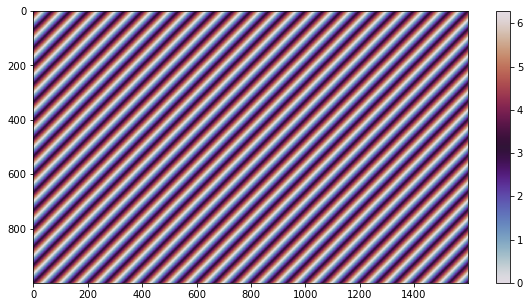

In [6]:
# slm = Santec(slm_number=1, display_number=2, wav_um=.515)
from slmsuite.hardware.slms.slm import SLM
slm = SLM(width=1600, height=1000, bitdepth=8)
blaze_phase_easy = toolbox.blaze(grid=slm, vector=(.001, .001))
plot_phase(blaze_phase_easy)

At startup, the SLM caches grids with appropriate `shape` and dimension, using the coordinates normalized to the target wavelength $(\frac{x}{\lambda}, \frac{y}{\lambda})$ which `blaze` expects. These grids are stored in `slm.x_grid` and `slm.x_grid`, and passing `grid=slm` is equivalent to passing `grid=(slm.x_grid, slm.y_grid)`.

Note that these grids are centered on the SLM, such that when we try other helper functions such as `slmsuite.holography.toolbox.lens`, the result is centered:

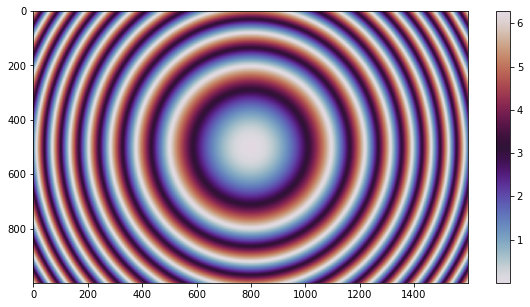

In [29]:
lens_phase = toolbox.lens(grid=slm, f=1e7)
plot_phase(lens_phase)

As before, units are normalized to wavelength, so passing `f=1e7` is equivalent to requesting a lens with a focal length of ten million wavelengths, or 5.15 meters at 515 nm.

We can of course pass more interesting lenses. For instance, an elliptical lens:

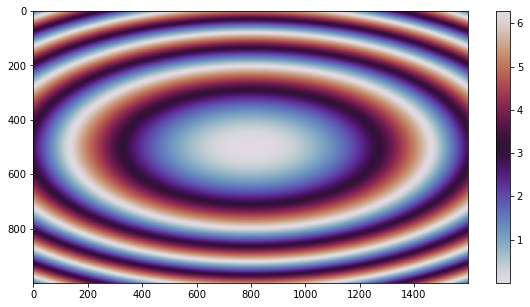

In [32]:
lens_phase = toolbox.lens(grid=slm, f=(5e7, 1e7))
plot_phase(lens_phase)

Or going further to a cylindrical lens:

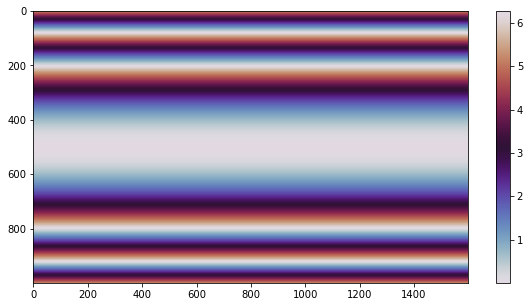

In [83]:
lens_phase = toolbox.lens(grid=slm, f=(np.inf, 1e7))
plot_phase(lens_phase)

Or rotate the lens about the center:

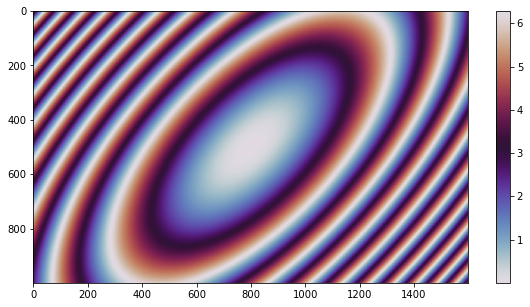

In [85]:
lens_phase = toolbox.lens(grid=slm, f=((5e7, 1e7), np.pi/4))
plot_phase(lens_phase)

Or shift the center across the SLM. Note that center, like other parameters in `slmsuite` is in normalized units. Fortunately, the `slm` has helper variables `dx` and `dy` which store the pixel size in normalized units, such that requesting a `(400, 200)` pixel shift is as simple as multiplying by these variables to convert to normalized units:

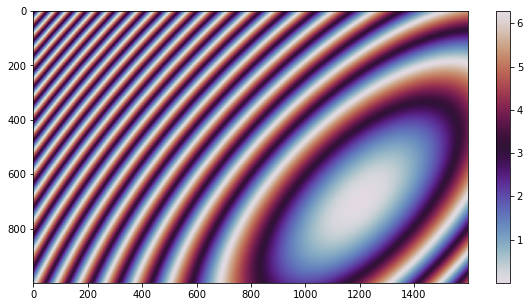

In [86]:
lens_phase = toolbox.lens(grid=slm, f=((5e7, 1e7), np.pi/4), center=(400*slm.dx, 200*slm.dy))
plot_phase(lens_phase)

#### Zernike Polynomials

TODO

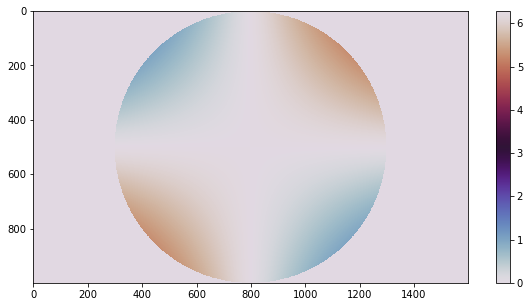

In [59]:
zernike_phase = toolbox.zernike(grid=slm, n=2, m=0, aperture="square")
plot_phase(zernike_phase)

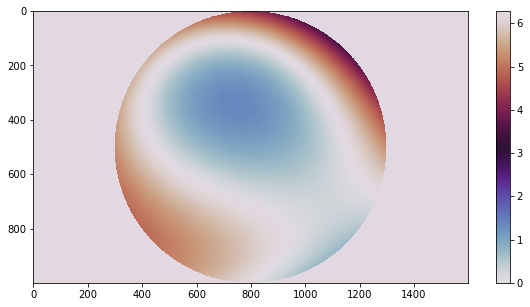

In [65]:
zernike_sum_phase = toolbox.zernike_sum(grid=slm, weights=(((2, 0), 1), ((2, 1), -1), ((3, 1), 1)), aperture="square")
plot_phase(zernike_sum_phase)

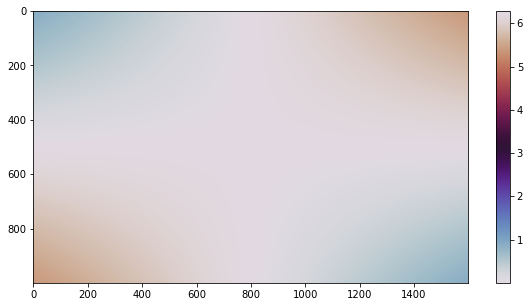

In [68]:
zernike_phase = toolbox.zernike(grid=slm, n=2, m=0, aperture="cropped")
plot_phase(zernike_phase)

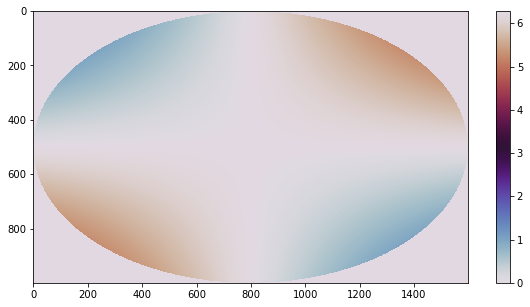

In [69]:
zernike_phase = toolbox.zernike(grid=slm, n=2, m=0, aperture="rectangular")
plot_phase(zernike_phase)

#### Segmented SLMs and `imprint`

In some cases, it is desirable to split an SLM into many individual regions. `slmsuite` has helper functions to support this.

The `slmsuite.toolbox.imprint()` operation 'imprints' a function such as `blaze` and `lens` from the previous section onto the SLM, but only in a given window. This window can be defined many ways (see API reference), but here we define it in `(x, w, y, h)` form. Extra keyword arguments to `imprint` are passed to the function.

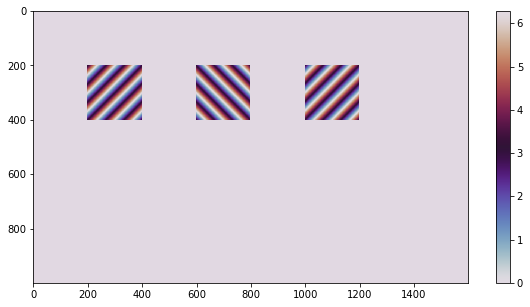

In [201]:
canvas = np.zeros(shape=slm.shape)

toolbox.imprint(canvas, window=[ 200, 200, 200, 200], grid=slm, function=toolbox.blaze, vector=(.001, .001))
toolbox.imprint(canvas, window=[ 600, 200, 200, 200], grid=slm, function=toolbox.blaze, vector=(-.001, .001))
toolbox.imprint(canvas, window=[1000, 200, 200, 200], grid=slm, function=toolbox.blaze, vector=(-.001, -.001))

plot_phase(canvas)

`imprint` supports two operation types:

- `imprint_operation="replace"`, the default, where the original phase on the `canvas` is overwritten, and
- `imprint_operation="add"`, where the original phase is instead added to.

As an example, phase in the middle window is zeroed, as the field had the negative of the imprinted phase. The right box adds to create a new vector.

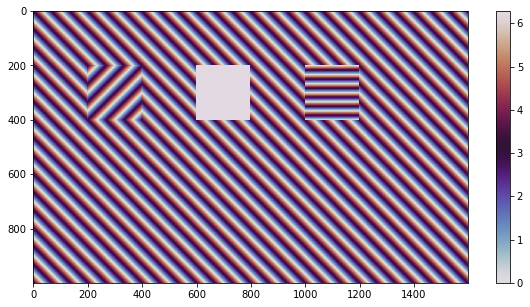

In [203]:
canvas = toolbox.blaze(grid=slm, vector=(.001, -.001))

toolbox.imprint(canvas,  [200, 200, 200, 200], grid=slm, function=toolbox.blaze, vector=(.001, .001), imprint_operation="replace")
toolbox.imprint(canvas,  [600, 200, 200, 200], grid=slm, function=toolbox.blaze, vector=(-.001, .001), imprint_operation="add")
toolbox.imprint(canvas, [1000, 200, 200, 200], grid=slm, function=toolbox.blaze, vector=(-.001, -.001), imprint_operation="add")

plot_phase(canvas)

Now suppose we want to something more complicated, with very many regions on the same SLM instead of a handful. As an example, we can make an array of microlenses on a grid. First of all, we have helper functions to construct the grid. The function `toolbox.get_affine_vectors()` can fit an affine transformation to three given vectors (`y0`, `y1`, `y2`), and return a grid of vectors with size `N`:

In [155]:
vectors = toolbox.get_affine_vectors(y0=(200,100), y1=(300,110), y2=(220, 200), N=(11,8))

See the API reference of `toolbox.get_affine_vectors()` for the full capabilities of the function. We can quickly visualize this to see we indeed have a grid:

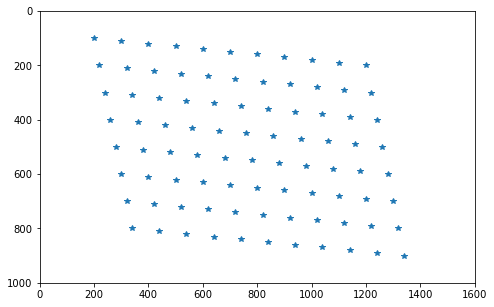

In [208]:
plt.figure(figsize=(10,5))
plt.plot(vectors[0,:], vectors[1,:], "*")
plt.xlim(0, slm.shape[1])
plt.ylim(slm.shape[0], 0)
plt.gca().set_aspect('equal')
plt.show()

Now we can use `imprint` to add a lens at each point. For now we'll use a width and height of `width = 50` pixels. We're also using the `centered` parameter of `imprint` such that the vector position of the window is `centered` instead of at the lower left corner.

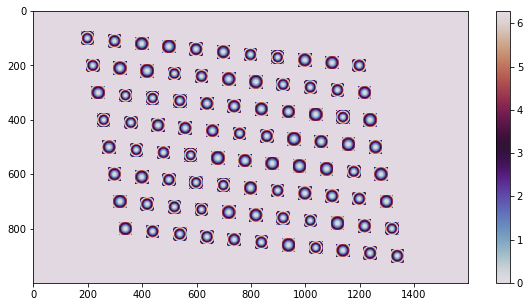

In [179]:
width = 50

def get_segmented_phase_square():
    N = vectors.shape[1]
    segmented_phase_square = np.zeros(shape=slm.shape)

    for x in range(N):
        vector_normalized = (   (vectors[0,x] - slm.shape[1]/2.) * slm.dx, 
                                (vectors[1,x] - slm.shape[0]/2.) * slm.dy   )
        toolbox.imprint(segmented_phase_square, [vectors[0,x], width, vectors[1,x], width], grid=slm, 
            function=toolbox.lens, f=np.random.uniform(5e4, 1e5), center=vector_normalized,
            centered=True)
    
    return segmented_phase_square

plot_phase(get_segmented_phase_square())

This is interesting, but we should try for better fill factor. We can use another helper function `toolbox.get_smallest_distance()` and a special metric to find the largest window size that doesn't collide with other boxes.

90.0


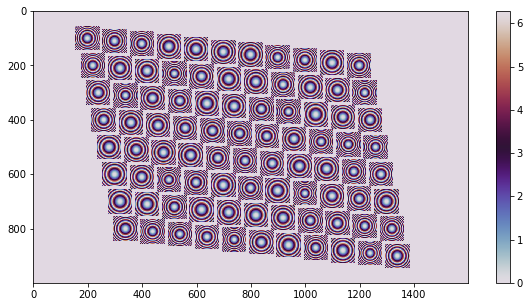

In [180]:
def metric(x, y):
    return np.max(np.abs(x - y))
width = toolbox.get_smallest_distance(vectors, metric=metric)
print(width)

plot_phase(get_segmented_phase_square())

Better, but there's still some empty space that we might want to fill. The helper function `toolbox.get_voronoi_windows` can help with this, making a Voronoi cell around each point.

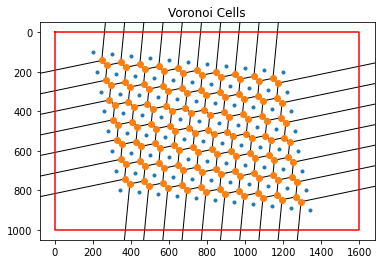

In [185]:
windows = toolbox.get_voronoi_windows(grid=slm.shape, vectors=vectors, plot=True)

This function returns a list of windows, where each window is a boolean array.

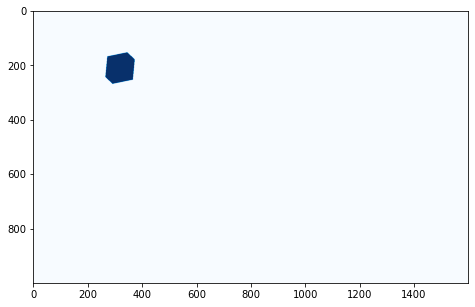

In [207]:
plt.figure(figsize=(10,5))
plt.imshow(windows[12])
plt.show()

Such windows can be passed to `imprint`, where the function will only be evaluated and imprinted within the defined area.

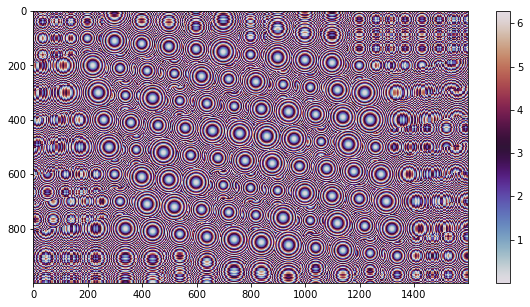

In [186]:
def get_segmented_phase():
    N = vectors.shape[1]
    segmented_phase = np.zeros(shape=slm.shape)

    for x in range(N):
        vector_normalized = (   (vectors[0,x] - slm.shape[1]/2.) * slm.dx, 
                                (vectors[1,x] - slm.shape[0]/2.) * slm.dy   )
        toolbox.imprint(segmented_phase, windows[x], grid=slm, 
            function=toolbox.lens, f=np.random.uniform(5e4, 1e5), center=vector_normalized)

    return segmented_phase

plot_phase(get_segmented_phase())

As a final step, we can use the `radius=` parameter of `get_voronoi_windows()` clip the edge voronoi cells to more reasonable sizes around the lenses, again using `get_smallest_distance`.

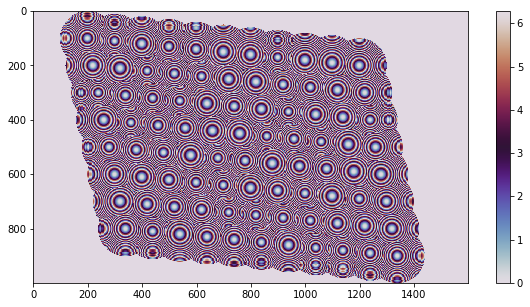

In [205]:
radius = toolbox.get_smallest_distance(vectors, metric=distance.euclidean)
windows = toolbox.get_voronoi_windows(grid=slm.shape, vectors=vectors, radius=radius, plot=False)

plot_phase(get_segmented_phase())

#### Structured Light Conversion

There are a number interesting optical modes whose farfield pattern is Gaussian in amplitude, with the addition of some phase. As the beam sourced on an SLM is often in a Gaussian mode, we can tune phase on the SLM to produce structured light in the nearfield of the camera. One example is a [Laguerre-Gaussian](https://en.wikipedia.org/wiki/Gaussian_beam#Laguerre-Gaussian_modes) mode, possessing the optical analog of [orbital angular momentum](https://en.wikipedia.org/wiki/Azimuthal_quantum_number). To start, we can take a look at the phase for a $LG_{lp} = LG_{10}$ mode, also known as a [vortex waveplate](https://en.wikipedia.org/wiki/Optical_vortex):

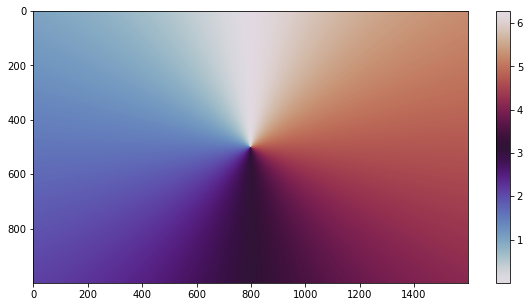

In [80]:
lg10_phase = toolbox.laguerre_gaussian(slm, l=1, p=0)
plot_phase(lg10_phase)

Higher order and more interesting modes are also possible, such as the $LG_{lp} = LG_{32}$ mode:

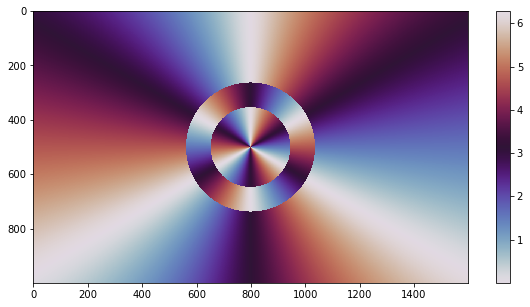

In [82]:
lg32_phase = toolbox.laguerre_gaussian(slm, l=3, p=2)
plot_phase(lg32_phase)

Let's take a look at what this looks like in the camera's domain:

In [ ]:
cam = AlliedVision(serial="02C5V", verbose=True, fliplr=True)

slm.write(lg32_phase, wait_for_settle=True)

plt.imshow(cam.get_image())
plt.show()

We can do cool things like shift the beam by adding a `blaze`.

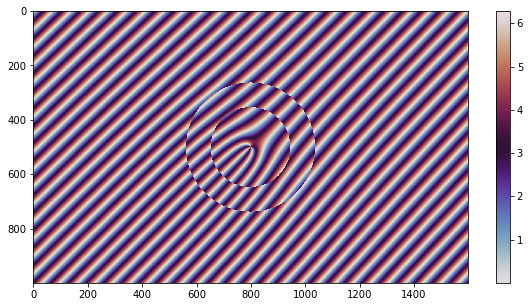

In [88]:
lg32_shifted_phase = lg32_phase + toolbox.blaze(grid=slm, vector=(.001, .001))
plot_phase(lg32_shifted_phase)

In [ ]:
slm.write(lg32_shifted_phase, wait_for_settle=True)

plt.imshow(cam.get_image())
plt.show()

Or we can defocus the beam by adding a `lens`.

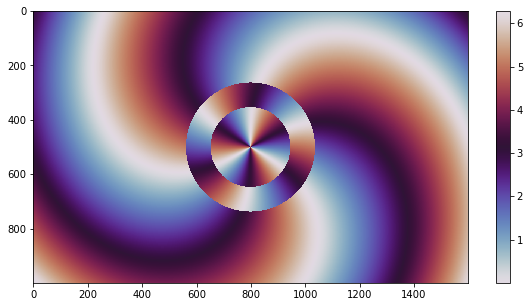

In [91]:
lg32_defocused_phase = lg32_phase + toolbox.lens(grid=slm, f=1e8)
plot_phase(lg32_defocused_phase)

In [ ]:
slm.write(lg32_defocused_phase, wait_for_settle=True)

plt.imshow(cam.get_image())
plt.show()

Although we admittedly haven't gotten around to implementing these yet, there are also `hermite_gaussian`, `ince_gaussian`, and `matheui_gaussian` beam conversion planned for `toolbox`.